In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = "D:/桌面/ESE5023_Assignments_12431305/PS2/earthquakes.tsv"  
Sig_Eqs = pd.read_csv(file_path, sep="\t")
Sig_Eqs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616 entries, 0 to 6615
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Search Parameters                   1 non-null      object 
 1   Year                                6615 non-null   float64
 2   Mo                                  6202 non-null   float64
 3   Dy                                  6045 non-null   float64
 4   Hr                                  4502 non-null   float64
 5   Mn                                  4289 non-null   float64
 6   Sec                                 3831 non-null   float64
 7   Tsu                                 2083 non-null   float64
 8   Vol                                 81 non-null     float64
 9   Location Name                       6615 non-null   object 
 10  Latitude                            6554 non-null   float64
 11  Longitude                           6554 no

In [41]:
# 1.1

#  从 Location Name 中抽取“国家/地区” —— 
# 规则：有冒号取冒号左侧；无冒号取整串；缺失为 NA；统一去空格
Sig_Eqs["Country"] = (
    Sig_Eqs["Location Name"].astype("string")
      .str.extract(r"^\s*([^:：]+)", expand=False)  # 提取开头到第一个冒号前的内容——国家
      .str.strip().replace("", pd.NA).str.upper())

#  “死亡人数”的选取（"Total Deaths" 还是"Deaths"）
# 优先用 'Total Deaths'，没有就'Deaths'
Deaths_real = "Total Deaths" if "Total Deaths" in Sig_Eqs.columns else "Deaths"

# 把死亡人数列转为数值（无法解析的记为 NaN）
Sig_Eqs[Deaths_real] = pd.to_numeric(Sig_Eqs[Deaths_real], errors="coerce")


# 按照国家名称分组求和
deaths_by_country = (
    Sig_Eqs.groupby("Country", dropna=True)[Deaths_real].sum(min_count=1).fillna(0).sort_values(ascending=False))

# 只取前 10 名（用 nlargest 少一次全量排序也可）
top10 = deaths_by_country.head(10).astype(int)

print("\n[1.1] 各国地震总死亡人数（前 10）：")
print(top10)


[1.1] 各国地震总死亡人数（前 10）：
Country
CHINA         2106535
TURKEY        1008342
IRAN           745611
ITALY          423280
SYRIA          417724
HAITI          323782
AZERBAIJAN     319251
JAPAN          318441
INDONESIA      282517
ARMENIA        189000
Name: Total Deaths, dtype: int64


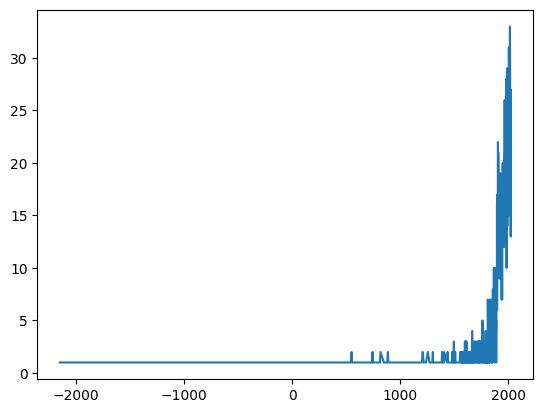

趋势和解释：从图看来，近几百年的6极以上地震“显著变多”，而千年之前几乎没有，但这更可能是几百年前数据缺失或者无法记录所致


In [42]:
# 1.2

# 确保用到的列为数值
Sig_Eqs["Mag"]  = pd.to_numeric(Sig_Eqs["Mag"],  errors="coerce")
Sig_Eqs["Year"] = pd.to_numeric(Sig_Eqs["Year"], errors="coerce")

# 震级 > 6.0
mag_6 = Sig_Eqs.loc[Sig_Eqs["Year"].notna() & Sig_Eqs["Mag"].notna() & (Sig_Eqs["Mag"] > 6.0)].copy()

# 按“年份”计数，并按年份升序排列
mag_6["Year_int"] = mag_6["Year"].astype(int)                   
mag_6_per_year = mag_6.groupby("Year_int").size().sort_index()  # 每年条数 = size()

#画折线图
plt.plot(m6_per_year.index, m6_per_year.values)
plt.show()
print("趋势和解释：从图看来，近几百年的6极以上地震“显著变多”，而千年之前几乎没有，但这更可能是几百年前数据缺失或者无法记录所致")
# 趋势和解释：从图看来，近几百年的6极以上地震“显著变多”，而千年之前几乎没有，但这更可能是几百年前数据缺失或者无法记录所致

In [44]:
#1.3

# 把 Year/Mo/Dy 组合成“尽量精确”的日期；无月日则回退到年份
def _best_date_string(y, m, d):
    if pd.isna(y): 
        return "N/A (无年份)"
    y = int(y)
    if y <= 0:  # BCE
        if pd.notna(m) and pd.notna(d):
            m, d = int(m), int(d)
            if 1 <= m <= 12 and 1 <= d <= 31:
                return f"{abs(y):04d}-{m:02d}-{d:02d} BCE"
        return f"{abs(y)} BCE"
    # CE
    if pd.notna(m) and pd.notna(d):
        m, d = int(m), int(d)
        ts = pd.to_datetime({"year":[y], "month":[m], "day":[d]}, errors="coerce")
        if ts.notna().iloc[0]:
            return ts.dt.strftime("%Y-%m-%d").iloc[0]
    return str(y)

# 返回（该国总地震次数，史上最大震级地震的日期）
def CountEq_LargestEq(country_name, data):
    sub = data.loc[data["Country"] == country_name]
    total_count = len(sub)
    if total_count == 0:
        return 0, "N/A (无记录)"
    sub_valid = sub.dropna(subset=["Mag"])
    if sub_valid.empty:
        return total_count, "N/A (无震级数据)"
    row = sub_valid.loc[sub_valid["Mag"].idxmax()]
    return total_count, _best_date_string(row.get("Year"), row.get("Mo"), row.get("Dy"))

# 应用到每个国家
rows = []
for c in sorted(Sig_Eqs["Country"].dropna().unique()):
    total, date_str = CountEq_LargestEq(c, Sig_Eqs)
    rows.append({"Country": c, "TotalEarthquakes": total, "LargestEarthquakeDate": date_str})

results_sorted = (
    pd.DataFrame(rows)
      .sort_values(["TotalEarthquakes", "Country"], ascending=[False, True])
      .reset_index(drop=True)
)

print("所有国家地震总数及最大地震日期 (按总数降序排列):")
print(results_sorted.to_string(index=False))

所有国家地震总数及最大地震日期 (按总数降序排列):
                                    Country  TotalEarthquakes LargestEarthquakeDate
                                      CHINA               626                  1668
                                  INDONESIA               404            2004-12-26
                                       IRAN               388                   856
                                      JAPAN               364            2011-03-11
                                     TURKEY               344            1939-12-26
                                      ITALY               332            1915-01-13
                                     GREECE               275                   365
                                PHILIPPINES               226            1897-09-21
                                     MEXICO               204            1787-03-28
                                      CHILE               200            1960-05-22
                                       PERU      

[OK] 2010–2020 有效行数：111346


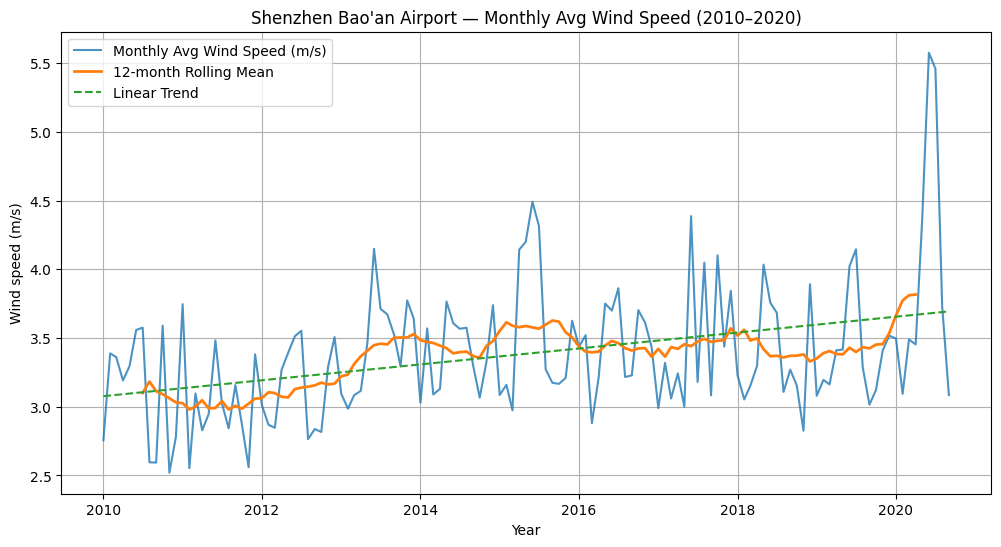

有效月份数：129
线性回归斜率：0.0048 m/s 每月  ≈  0.0578 m/s 每年  ≈  0.5782 m/s 每十年
R²：0.1354
平均风速呈现上升趋势


In [64]:
# 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件
file = "D:/桌面/ESE5023_Assignments_12431305/PS2/2281305.csv"

# 读需要的 column
wind_data = pd.read_csv(file, usecols=['DATE', 'WND'], dtype=str, low_memory=False)

# 时间与风速解析
#日期转换
wind_data['DATE'] = pd.to_datetime(wind_data['DATE'], errors='coerce')

#解析 WND：第4个字段为风速，第5个为质量码
def parse_wind_speed(wnd_string: str):
    try:
        parts = str(wnd_string).split(',')
        spd = parts[3]     # 0.1 m/s
        qc  = parts[4]     # 质量码
        if qc not in {'0', '1', '4', '5', '9'}:
            return np.nan
        if spd == '9999':
            return np.nan
        return float(spd) / 10.0
    except Exception:
        return np.nan

wind_data['Wind_Speed'] = wind_data['WND'].apply(parse_wind_speed)

# 丢弃解析失败的记录
wind_data = wind_data.dropna(subset=['DATE', 'Wind_Speed'])

# 过滤到 2010–2020 
shenzhen_2010_2020 = (wind_data['DATE'] >= '2010-01-01') & (wind_data['DATE'] <= '2020-12-31')
wind_data = wind_data.loc[shenzhen_2010_2020].copy()

print(f"[OK] 2010–2020 有效行数：{len(wind_data)}")

#计算“月平均风速”
monthly_avg = (
    wind_data.set_index('DATE')['Wind_Speed']
             .resample('MS')  # 月初频率
             .mean()
             .dropna()
)

# 12 个月居中滚动均值
rolling_12m = monthly_avg.rolling(window=12, center=True).mean()

# 线性回归趋势
x = np.arange(len(monthly_avg), dtype=float)
y = monthly_avg.values.astype(float)

# 拟合直线
slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept

# R²
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

#绘图 
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, label='Monthly Avg Wind Speed (m/s)', alpha=0.8)
plt.plot(rolling_12m.index, rolling_12m.values, label='12-month Rolling Mean', linewidth=2.0)
plt.plot(monthly_avg.index, y_fit, linestyle='--', label='Linear Trend')  # 不指定颜色
plt.title("Shenzhen Bao'an Airport — Monthly Avg Wind Speed (2010–2020)")
plt.xlabel("Year")
plt.ylabel("Wind speed (m/s)")
plt.grid(True)
plt.legend(loc="best")
plt.show()

# 统计数据
per_month  = slope
per_year   = per_month * 12.0
per_decade = per_year * 10.0
print(f"有效月份数：{len(monthly_avg)}")
print(f"线性回归斜率：{per_month:.4f} m/s 每月  ≈  {per_year:.4f} m/s 每年  ≈  {per_decade:.4f} m/s 每十年")
print(f"R²：{r2:.4f}")
print("平均风速呈现上升趋势")

In [7]:
#3-1 对地震中心深度的无效数据进行过滤

# 将“Focal Depth (km)”转为数值、丢弃无法转换的行，并按深度从大到小排序
Sig_Eqs = (
    Sig_Eqs.assign(**{"Focal Depth (km)": pd.to_numeric(Sig_Eqs["Focal Depth (km)"], errors="coerce")})
           .dropna(subset=["Focal Depth (km)"]).sort_values(by="Focal Depth (km)", ascending=False)
           .reset_index(drop=True)
)
Sig_Eqs

,Search Parameters,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,...,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description,Country
0,NaN,2002.0,8.0,19.0,11.0,8.0,24.3,NaN,NaN,FIJI ISLANDS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FIJI ISLANDS
1,NaN,2018.0,9.0,6.0,15.0,49.0,18.7,NaN,NaN,FIJI ISLANDS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FIJI ISLANDS
2,NaN,2015.0,5.0,30.0,11.0,23.0,2.1,NaN,NaN,JAPAN: BONIN ISLANDS [CHICHIJIMA ISLAND],...,NaN,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,JAPAN
3,NaN,1970.0,7.0,31.0,17.0,8.0,5.4,NaN,NaN,PERU: JUIN PROVINCE FELT ARGENTINA TO MEXICO...,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,PERU
4,NaN,1921.0,12.0,18.0,15.0,29.0,0.0,NaN,NaN,PERU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PERU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3569,NaN,2013.0,8.0,7.0,9.0,6.0,52.2,NaN,NaN,"GREECE: CENTRAL: PHTHIOTIS, REGGINI",...,NaN,NaN,NaN,NaN,2.0,100.0,2.0,NaN,NaN,GREECE
3570,NaN,1988.0,9.0,6.0,0.0,42.0,33.7,NaN,NaN,PAPUA NEW GUINEA: KAIAPIT (LANDSLIDE GENERATED),...,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,PAPUA NEW GUINEA
3571,NaN,2014.0,2.0,26.0,0.0,0.0,7.0,NaN,NaN,AUSTRALIA: KALGOORLIE,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,AUSTRALIA
3572,NaN,1938.0,11.0,6.0,8.0,53.0,53.0,1718.0,NaN,JAPAN: OFF EAST COAST HONSHU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAPAN


Text(0, 0.5, 'Number of Earthquakes')

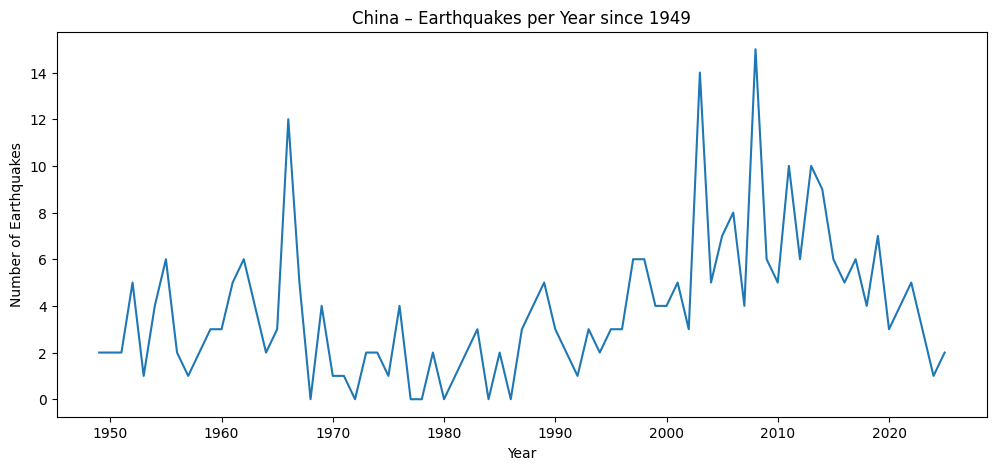

In [5]:
#3-2新中国以来每年的地震次数

# 读数据 
file_path = r"D:/桌面/ESE5023_Assignments_12431305/PS2/earthquakes.tsv"
Sig_Eqs = pd.read_csv(file_path, sep="\t")

# 抽取国家、清洗年份 
# 国家：从 Location Name 的第一个冒号(支持中英文)左侧提取；统一大写
Sig_Eqs["Country"] = (
    Sig_Eqs["Location Name"].astype("string")
      .str.extract(r"^\s*([^:：]+)", expand=False)
      .str.strip()
      .replace("", pd.NA)
      .str.upper()
)

# 年份转为数值
Sig_Eqs["Year"] = pd.to_numeric(Sig_Eqs["Year"], errors="coerce")

# 统计中国1949年以来每年的地震次数 
china = Sig_Eqs[(Sig_Eqs["Country"] == "CHINA") & (Sig_Eqs["Year"] >= 1949)].dropna(subset=["Year"]).copy()
china["Year"] = china["Year"].astype(int)

# 计数
counts = china.groupby("Year").size().rename("Earthquake_Count")

# 补齐年份（1949 ~ 数据中中国地震的最大年份），空缺填0
year_min, year_max = 1949, (int(china["Year"].max()) if not china.empty else 1949)
counts = counts.reindex(range(year_min, year_max + 1), fill_value=0)


# 绘图：折线图
plt.figure(figsize=(12, 5))
plt.plot(counts.index, counts.values)
plt.title("China – Earthquakes per Year since 1949")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")



In [11]:
#3-32000年以来、深度大于30km、地震等级大于5级、死亡人数大于100的地震总结

import pandas as pd

# 读取数据 
file_path = r"D:/桌面/ESE5023_Assignments_12431305/PS2/earthquakes.tsv"
Sig_Eqs = pd.read_csv(file_path, sep="\t")

# 从 Location Name 抽取国家
Sig_Eqs["Country"] = (
    Sig_Eqs["Location Name"].astype("string")
      .str.extract(r"^\s*([^:：]+)", expand=False)  # 取第一个冒号前的文本
      .str.strip()
      .replace("", pd.NA)
      .str.upper()
)

# 死亡人数列（优先 Total Deaths，否则 Deaths），并转为数值
Deaths_real = "Total Deaths" if "Total Deaths" in Sig_Eqs.columns else "Deaths"
Sig_Eqs[Deaths_real] = pd.to_numeric(Sig_Eqs[Deaths_real], errors="coerce")

# 把 Year、Mag、Focal Depth (km) 转为数值
Sig_Eqs["Year"] = pd.to_numeric(Sig_Eqs["Year"], errors="coerce")
Sig_Eqs["Mag"]  = pd.to_numeric(Sig_Eqs["Mag"], errors="coerce")
Sig_Eqs["Focal Depth (km)"] = pd.to_numeric(Sig_Eqs["Focal Depth (km)"], errors="coerce")

# 筛选条件——Year >= 2000、深度 > 30、震级 > 5、死亡人数 > 100 
cond = (
    (Sig_Eqs["Year"] >= 2000) &
    (Sig_Eqs["Focal Depth (km)"] > 30) &
    (Sig_Eqs["Mag"] > 5) &
    (Sig_Eqs[Deaths_real] > 100)
)

# 按国家排序；同一国家内按死亡人数降序 
cols_show = ["Country", "Year", "Mag", "Focal Depth (km)", Deaths_real, "Location Name"]
filtered = (
    Sig_Eqs.loc[cond, cols_show]
           .sort_values(["Country", Deaths_real], ascending=[True, False])
           .reset_index(drop=True)
)

print("=== 2000年以来，深度>30km、M>5、死亡>100 的地震清单（按国家排序） ===")
if filtered.empty:
    print("无记录")
else:
    print(filtered.to_string(index=False))

# 按国家汇总：事件数、死亡总数（按国家字母序） 
summary = (
    filtered.groupby("Country", as_index=False)
            .agg(Quake_Count=("Year", "count"),
                 Total_Deaths=(Deaths_real, "sum"))
            .sort_values("Country")
            .reset_index(drop=True)
)

print("\n=== 按国家汇总（事件数 / 死亡总数） ===")
if summary.empty:
    print("无记录")
else:
    print(summary.to_string(index=False))


=== 2000年以来，深度>30km、M>5、死亡>100 的地震清单（按国家排序） ===
               Country   Year  Mag  Focal Depth (km)  Total Deaths                                       Location Name
           AFGHANISTAN 2015.0  7.5             231.0         399.0                             AFGHANISTAN: HINDU KUSH
           AFGHANISTAN 2002.0  7.4             226.0         166.0 AFGHANISTAN:  HINDU KUSH:  SAMANGHAN, KABUL, RUSTAQ
EL SALVADOR; GUATEMALA 2001.0  7.7              60.0         844.0                              EL SALVADOR; GUATEMALA
                 INDIA 2011.0  6.9              50.0         127.0              INDIA: SIKKIM;  NEPAL;  CHINA;  BHUTAN
             INDONESIA 2009.0  7.5              81.0        1117.0                        INDONESIA:  SUMATRA:  PADANG
             INDONESIA 2018.0  6.9              34.0         560.0                           INDONESIA:  LOMBOK ISLAND
             INDONESIA 2000.0  7.9              33.0         103.0             INDONESIA:  SUMATRA:  BENGKULU, ENGGANO
